In [1]:
#%load_ext line_profiler
#%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.DEBUG)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot

Using TensorFlow backend.
/Users/edu/miniconda3/envs/yass/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
yass.set_config("../config/49-local.yaml")
CONFIG = read_config()

DEBUG:yass.config.config:Loaded from file: ../config/49-local.yaml
DEBUG:yass:CONFIG set to: {'data': {'root_folder': '/Users/Edu/data', 'recordings': 'ej49_data1_set1.bin', 'geometry': 'ej49_geometry1.txt'}, 'resources': {'max_memory': '100MB', 'max_memory_gpu': '1GB', 'processes': 'max'}, 'recordings': {'dtype': 'int16', 'sampling_rate': 20000, 'n_channels': 49, 'spatial_radius': 70, 'spike_size_ms': 1, 'order': 'samples'}, 'preprocess': {'apply_filter': True, 'dtype': 'float32', 'if_file_exists': 'skip', 'filter': {'order': 3, 'low_pass_freq': 300, 'high_factor': 0.1}}, 'detect': {'method': 'threshold', 'temporal_features': 3, 'save_results': False, 'if_file_exists': 'skip', 'neural_network_detector': {'filename': '/Users/edu/dev/lab/yass/src/yass/assets/models/detect_nn1.ckpt', 'threshold_spike': 0.5}, 'neural_network_triage': {'filename': '/Users/edu/dev/lab/yass/src/yass/assets/models/triage_nn1.ckpt', 'threshold_collision': 0.5}, 'neural_network_autoencoder': {'filename': '/User

In [5]:
path_to_data = path.expanduser('~/data')

path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 5

## Templates

In [7]:
gt.shape

(164406, 2)

## Generating training data

In [8]:
n_isolated_spikes = 500
min_amplitude = 5
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [9]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_isolated_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True)

INFO:yass.templates.preprocess:Getting templates...
INFO:yass.templates.util:Computing templates...
DEBUG:yass.batch.generator:Max memory: 100 MB. Itemsize: 4 bytes
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:yass.batch.generator:Observations per channel: 6,000,000. Number of channels: 49. Total observations: 294,000,000 Size to traverse: 1.1 GB
DEBUG:yass.batch.generator:Max observations per batch: 26,214,363 (100 MB), 534,987 max observations per channel
DEBUG:yass.batch.generator:Number of batches: 12
DEBUG:yass.batch.generator:Last batch with 5,642,007 observations (22568028), 115,143 observations per channel
DEBUG:yass.batch.util:Processing batch 0...
DEBUG:yass.batch.util:Applying function in batch 0 with size (535067, 49)
DEBUG:yass.batch.util:Done Applying function in batch 0...
  8%|▊         | 1/12 [00:01<00:15,  1.38s/it]DEBUG:yass.batch.util:Processing batch 1...
DEBUG:yass.batch.util:

DEBUG:yass.templates.crop:Template 30 will be shifted by 2
DEBUG:yass.templates.crop:Template 31 will be shifted by 2
DEBUG:yass.templates.crop:Template 32 will be shifted by 2
DEBUG:yass.templates.crop:Template 33 will be shifted by 2
DEBUG:yass.templates.crop:Template 34 will be shifted by 1
DEBUG:yass.templates.crop:Template 35 will be shifted by 2
DEBUG:yass.templates.crop:Template 36 will be shifted by 2
DEBUG:yass.templates.crop:Template 37 will be shifted by 2
DEBUG:yass.templates.crop:Template 38 will be shifted by 2
DEBUG:yass.templates.crop:Template 39 will be shifted by 2
DEBUG:yass.templates.crop:Template 40 will be shifted by -1


In [10]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(6929, 21, 7)
	triage:(1066, 21, 7)
	autoencoder:(5226, 21)


In [11]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

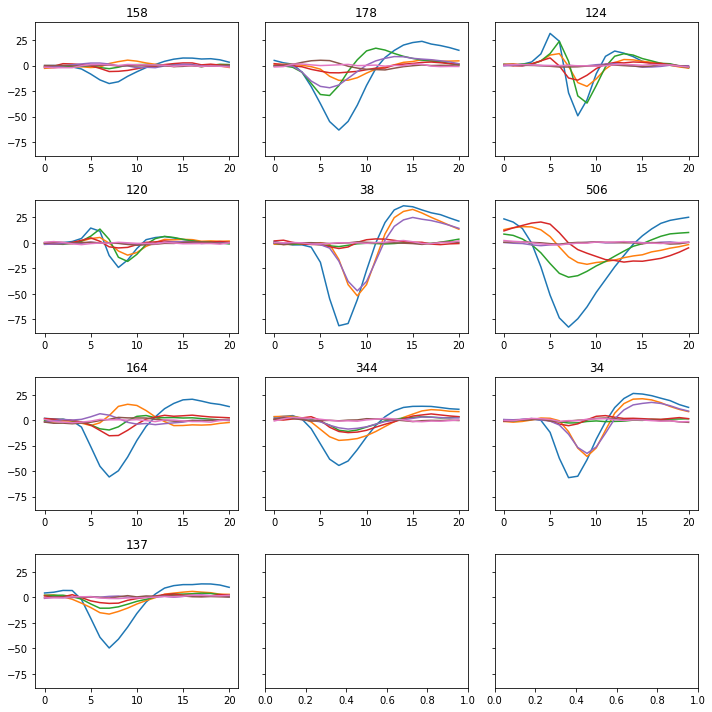

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_positive, axis=0, elements=10, sharey=True)

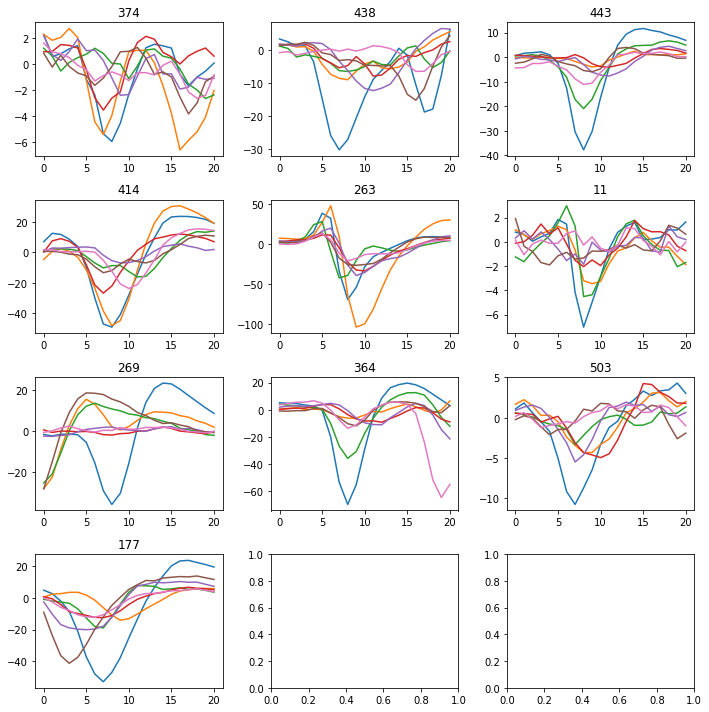

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_negative, axis=0, elements=10, sharey=False)

## Manually generating collisions

In [14]:
import os
from yass.templates import preprocess
from yass.augment.util import (make_noisy, make_clean, make_collided,
                               make_misaligned, make_noise)

collision_ratio = 1
multi_channel = True

path_to_data = os.path.join(path_to_experiment, 'preprocess',
                            'standarized.bin')

templates, templates_uncropped = preprocess(CONFIG, gt,
                                            path_to_data,
                                            chosen_templates)

_, _, n_neigh = templates.shape
K, _, n_channels = templates_uncropped.shape

# make training data set
R = CONFIG.spike_size
amps = np.max(np.abs(templates), axis=1)

# make clean augmented spikes
nk = int(np.ceil(n_isolated_spikes/K))
max_amp = np.max(amps) * 1.5
max_shift = 2*R

# make clean spikes
x_clean = make_clean(templates, min_amplitude, max_amp, nk)

INFO:yass.templates.preprocess:Getting templates...
INFO:yass.templates.util:Computing templates...
DEBUG:yass.batch.generator:Max memory: 100 MB. Itemsize: 4 bytes
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:yass.batch.generator:Observations per channel: 6,000,000. Number of channels: 49. Total observations: 294,000,000 Size to traverse: 1.1 GB
DEBUG:yass.batch.generator:Max observations per batch: 26,214,363 (100 MB), 534,987 max observations per channel
DEBUG:yass.batch.generator:Number of batches: 12
DEBUG:yass.batch.generator:Last batch with 5,642,007 observations (22568028), 115,143 observations per channel
DEBUG:yass.batch.util:Processing batch 0...
DEBUG:yass.batch.util:Applying function in batch 0 with size (535067, 49)
DEBUG:yass.batch.util:Done Applying function in batch 0...
  8%|▊         | 1/12 [00:03<00:43,  3.93s/it]DEBUG:yass.batch.util:Processing batch 1...
DEBUG:yass.batch.util:

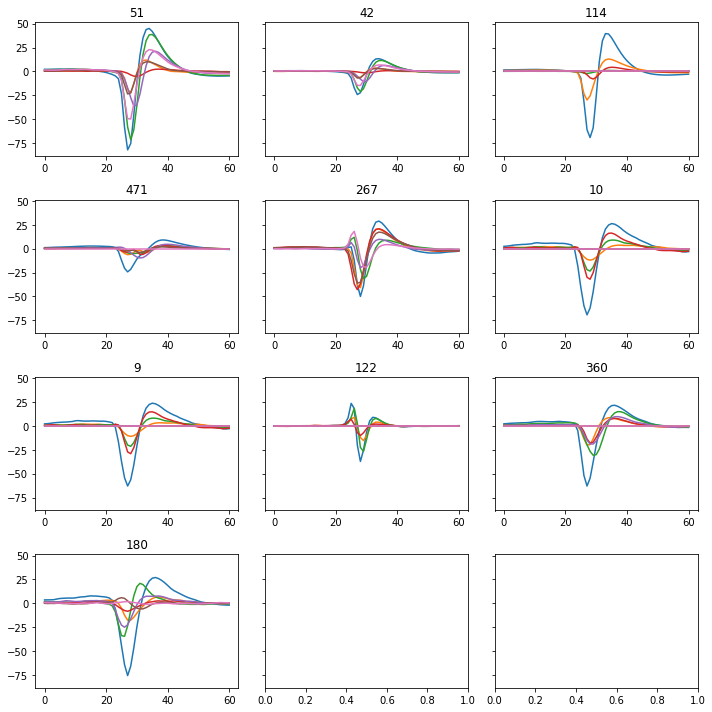

In [15]:
plot.grid_from_array(x_clean,
                     axis=0,
                     elements=10, 
                     sharey=True)

In [18]:
yass._enable_debug_mode(True)
random.seed(0)
np.random.seed(0)

# make collided spikes
x_collision, x_to_collide = make_collided(x_clean, collision_ratio,
                                          multi_channel,
                                          n_neigh)

DEBUG:yass.augment.util:Making collided spikes with max shift: 30, clean spikes with shape: (533, 61, 7)
INFO:yass.augment.util:Running in debug mode...


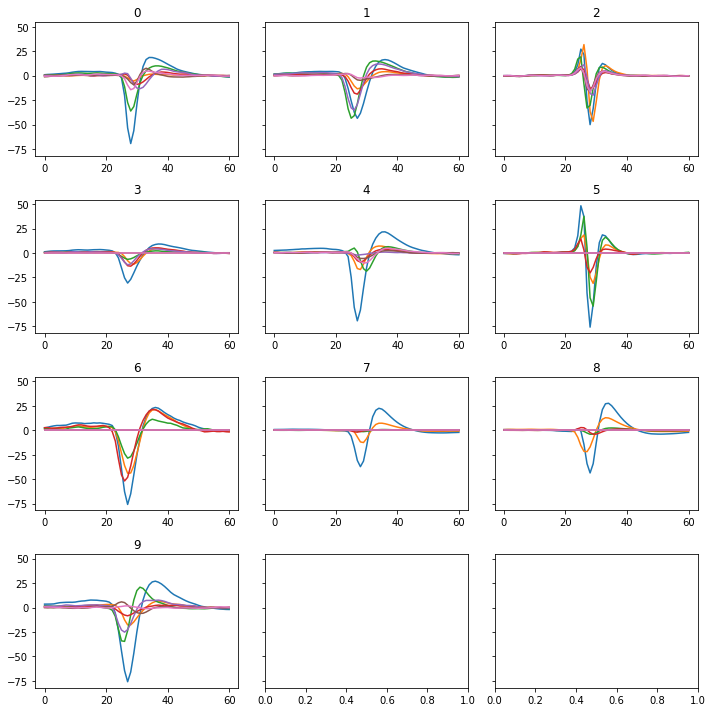

In [19]:
plot.grid_from_array(x_collision, axis=0,
                     elements=range(10), sharey=True)

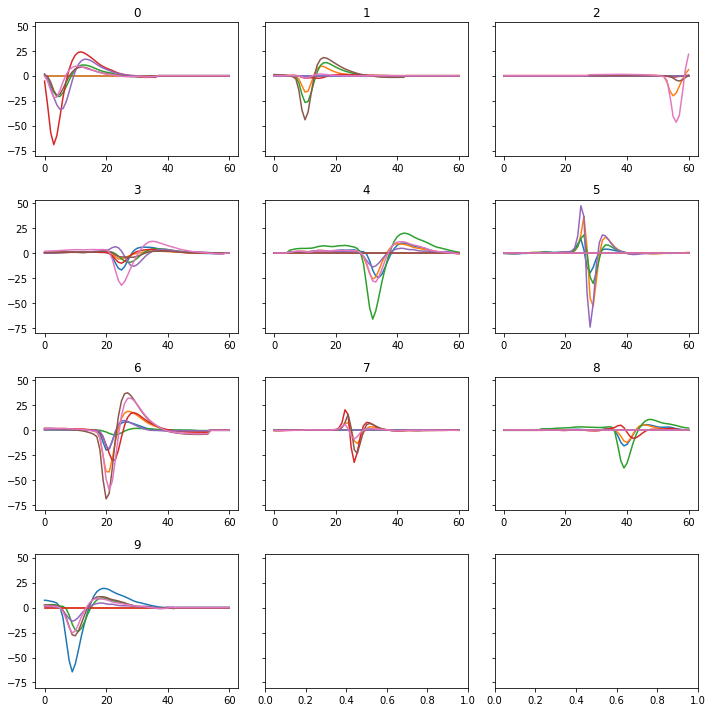

In [20]:
plot.grid_from_array(x_to_collide, axis=0,
                     elements=range(10), sharey=True)

In [22]:
random.seed(0)
np.random.seed(0)
yass._enable_debug_mode(False)

# make collided spikes

x_collided = make_collided(x_clean, collision_ratio,
                           multi_channel, n_neigh)

DEBUG:yass.augment.util:Making collided spikes with max shift: 30, clean spikes with shape: (533, 61, 7)


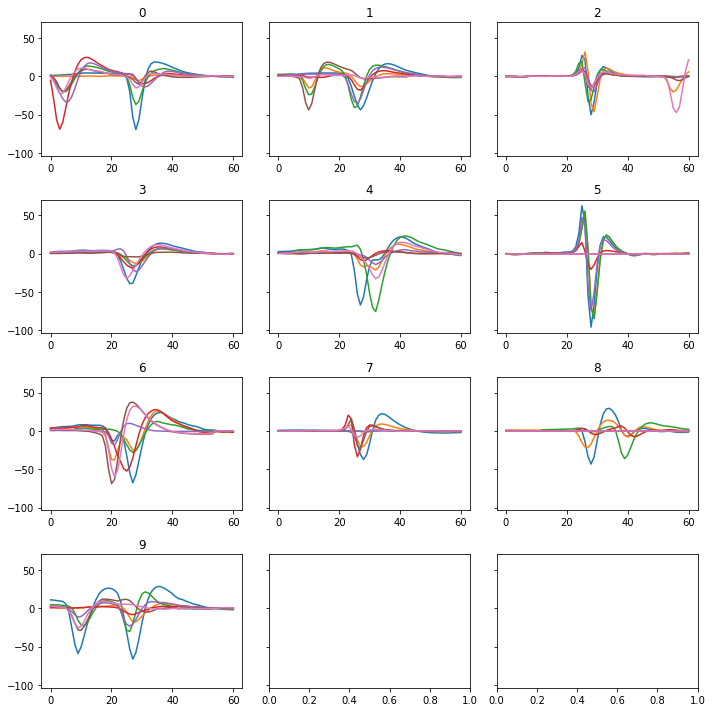

In [23]:
plot.grid_from_array(x_collided, axis=0,
                     elements=range(10), sharey=True)